In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize

(512, 512, 3)


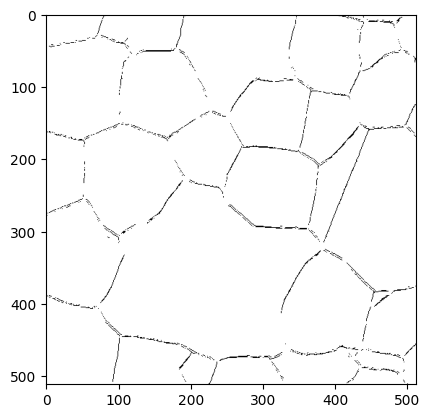

In [3]:
img = cv2.imread('output_mask.png', cv2.IMREAD_COLOR)
print(img.shape)
plt.imshow(img)

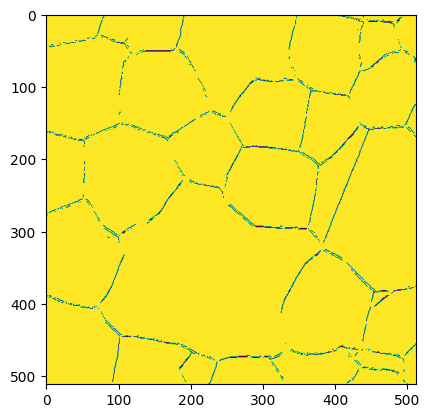

In [4]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img_gray)

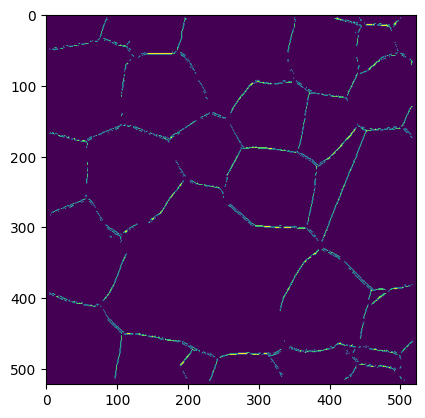

In [5]:
_, binary_img = cv2.threshold(img_gray, 127, 255, cv2.THRESH_BINARY_INV)
pad_img = np.pad(binary_img, pad_width=((5,5),(5,5)), mode='constant', constant_values=0)
plt.imshow(pad_img)

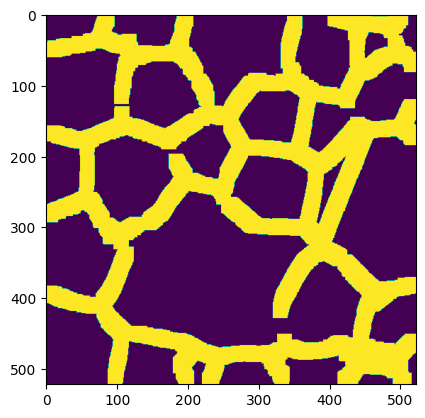

In [6]:
kernel = np.ones((3,3), np.uint8)
dilated = cv2.dilate(pad_img, kernel, iterations=10)
plt.imshow(dilated)

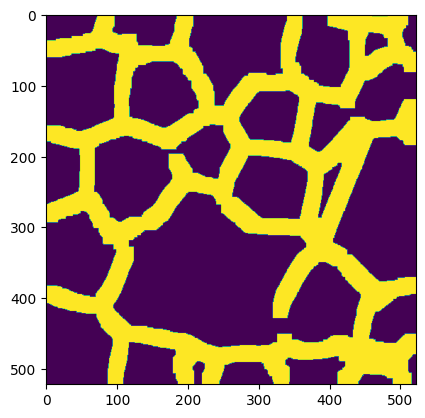

In [7]:
closed = cv2.morphologyEx(dilated, cv2.MORPH_CLOSE, kernel=np.ones((5,5), np.uint8), iterations=1)
plt.imshow(closed)

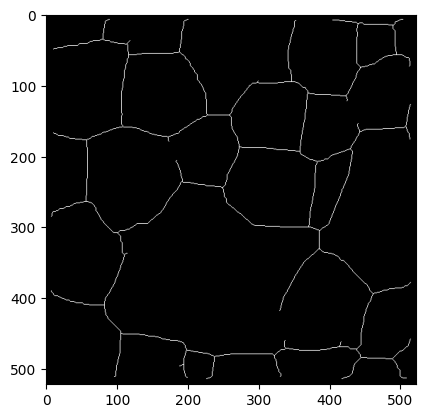

In [8]:
skeleton = skeletonize(closed // 255).astype(np.uint8) * 255
# final_skeleton = skeleton[5:-5, 5:-5]
plt.imshow(skeleton, cmap='gray')

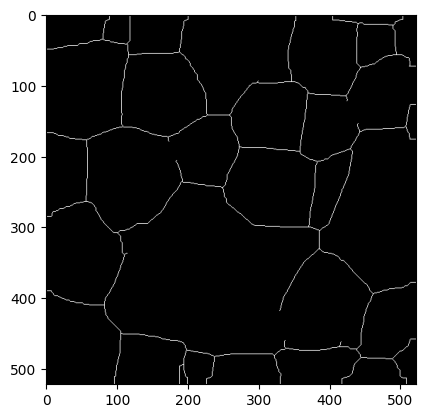

In [14]:
connected_skeleton = connect_endpoints_to_edges(skeleton, threshold=50)
plt.imshow(connected_skeleton, cmap='gray')

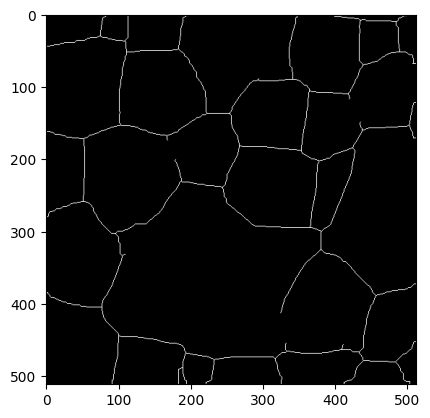

In [15]:
connected_skeleton = connected_skeleton[5:-5, 5:-5]
plt.imshow(connected_skeleton, cmap='gray')

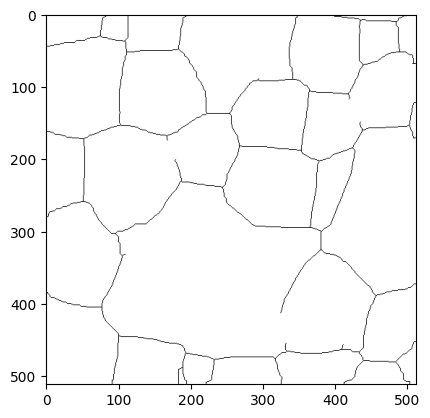

In [16]:
final_img = np.ones_like(connected_skeleton, dtype=np.uint8) * 255
final_img[connected_skeleton == 255] = 0
plt.imshow(final_img, cmap='gray')

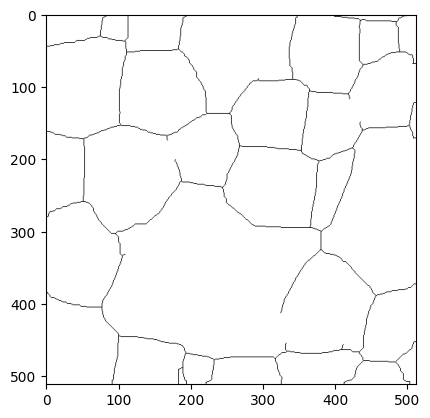

In [17]:
skeleton_bgr = cv2.cvtColor(final_img, cv2.COLOR_GRAY2BGR)
plt.imshow(skeleton_bgr)

In [12]:
cv2.imwrite('xhk.png', final_img)

True

In [13]:
# 끝점을 정확히 찾는 함수
def find_endpoints(skel):
    endpoints = []
    h, w = skel.shape
    for y in range(1, h - 1):
        for x in range(1, w - 1):
            if skel[y, x] == 255:
                neighborhood = skel[y-1:y+2, x-1:x+2]
                if np.sum(neighborhood == 255) == 2:  # 본인 포함 2픽셀(즉 주변 픽셀 1개만 연결된 상태)
                    endpoints.append((y, x))
    return endpoints

# 끝점들을 가장자리와 연결하는 함수
def connect_endpoints_to_edges(skeleton, threshold=50):
    h, w = skeleton.shape
    endpoints = find_endpoints(skeleton)
    connected = skeleton.copy()

    for y, x in endpoints:
        # 각 끝점에서 가장 가까운 가장자리 판단
        distances = {'left': x, 'right': w - x - 1, 'top': y, 'bottom': h - y - 1}
        closest_edge, min_dist = min(distances.items(), key=lambda item: item[1])

        # threshold 내의 가장자리로 연결
        if min_dist < threshold:
            if closest_edge == 'left':
                cv2.line(connected, (x, y), (0, y), 255, 1)
            elif closest_edge == 'right':
                cv2.line(connected, (x, y), (w - 1, y), 255, 1)
            elif closest_edge == 'top':
                cv2.line(connected, (x, y), (x, 0), 255, 1)
            elif closest_edge == 'bottom':
                cv2.line(connected, (x, y), (x, h - 1), 255, 1)

    return connected